Saving breastcancer.csv to breastcancer (4).csv
Cancer Type Detailed
Breast Invasive Ductal Carcinoma             66
Invasive Breast Carcinoma                    36
Breast Mixed Ductal and Lobular Carcinoma    11
Breast Invasive Lobular Carcinoma             5
Breast                                        2
Breast Invasive Mixed Mucinous Carcinoma      1
Name: count, dtype: int64
Original dataset shape: (121, 39)
Filtered dataset shape: (120, 39)
Removed 1 samples with rare cancer types
Epoch 1: loss nan
Epoch 2: loss nan
Epoch 3: loss nan
Epoch 4: loss nan
Epoch 5: loss nan
Epoch 6: loss nan
Epoch 7: loss nan
Epoch 8: loss nan
Epoch 9: loss nan
Epoch 10: loss nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-6f66b122773d>:172: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Transformers version: 4.51.3


Step,Training Loss
1,1.948100
2,1.850800
3,1.564100
4,1.535800
5,1.799700
6,1.615400
7,1.479600
8,1.621000
9,1.343000
10,1.321600


BioBERT Evaluation Results: {'eval_loss': 1.1069930791854858, 'eval_runtime': 31.6549, 'eval_samples_per_second': 0.758, 'eval_steps_per_second': 0.095, 'epoch': 2.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


     Model  Accuracy  Precision  Recall      F1
0      CNN    0.0417     0.0083     0.2  0.0160
1  BioBERT    0.5417     0.1083     0.2  0.1405


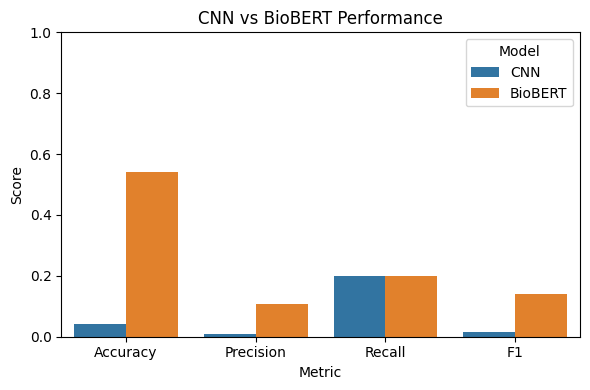

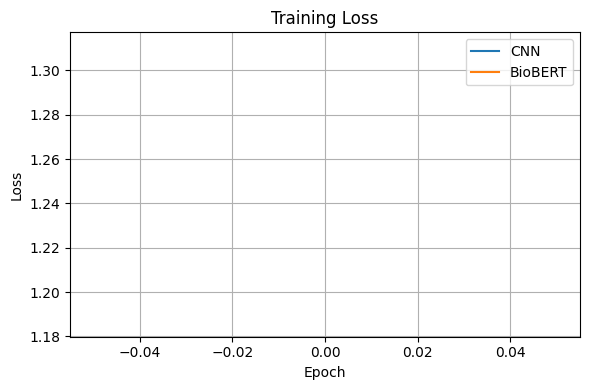

In [ ]:
from IPython import get_ipython
from IPython.display import display
# =========================================================
# 0. Setup
# =========================================================
!pip -q install pandas scikit-learn torch torchvision transformers datasets evaluate seaborn matplotlib

import pandas as pd, numpy as np, torch, torch.nn as nn, torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from tqdm.auto import tqdm
# Import datasets after transformers
import datasets
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)

# =========================================================
# 1. Upload & load data
# =========================================================
uploaded = files.upload()          # choose breastcancer.csv
df = pd.read_csv(next(iter(uploaded)))

target = "Cancer Type Detailed"
features = [
"Study ID","Patient ID","Sample ID","Age at Diagnosis","Type of Breast Surgery",
"Cancer Type","Cellularity","Chemotherapy","Pam50 + Claudin-low subtype","Cohort",
"ER status measured by IHC","ER Status","Neoplasm Histologic Grade","HER2 status measured by SNP6",
"HER2 Status","Tumor Other Histologic Subtype","Hormone Therapy","Inferred Menopausal State",
"Integrative Cluster","Primary Tumor Laterality","Lymph nodes examined positive",
"Mutation Count","Nottingham prognostic index","Oncotree Code","Overall Survival (Months)",
"Overall Survival Status","PR Status","Radio Therapy","Relapse Free Status (Months)",
"Relapse Free Status","Number of Samples Per Patient","Sample Type","Sex",
"3-Gene classifier subtype","TMB (nonsynonymous)","Tumor Size","Tumor Stage",
"Patient's Vital Status"
]

# Descriptive stats for target
print(df[target].value_counts())

# =========================================================
# 2. Pre-processing for CNN (tabular → numeric matrix)
# =========================================================
# Filter out classes with only one sample
class_counts = df[target].value_counts()
classes_to_keep = class_counts[class_counts >= 2].index.tolist()
df_filtered = df[df[target].isin(classes_to_keep)].copy()

print(f"Original dataset shape: {df.shape}")
print(f"Filtered dataset shape: {df_filtered.shape}")
print(f"Removed {len(df) - len(df_filtered)} samples with rare cancer types")

cat_cols = [c for c in features if df_filtered[c].dtype == "object"]
num_cols = [c for c in features if c not in cat_cols]

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

X = pre.fit_transform(df_filtered[features])
y_classes = sorted(df_filtered[target].unique())
y = df_filtered[target].map({c:i for i,c in enumerate(y_classes)}).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

# reshape for 1-D CNN: (batch, channels=1, length)
def to_loader(X, y, bs=64):
    tens_x = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    tens_y = torch.tensor(y, dtype=torch.long)
    return DataLoader(TensorDataset(tens_x, tens_y), batch_size=bs, shuffle=True)

train_loader = to_loader(X_train, y_train)
test_loader  = to_loader(X_test,  y_test, bs=128)

# =========================================================
# 3. CNN model
# =========================================================
class Simple1DCNN(nn.Module):
    def __init__(self, input_len, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(64, n_classes)
        )
    def forward(self, x): return self.net(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
cnn = Simple1DCNN(X.shape[1], len(y_classes)).to(device)
opt = optim.Adam(cnn.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

cnn_loss_hist = []
for epoch in range(10):
    cnn.train()
    running = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = cnn(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()
        running += loss.item()*len(xb)
    cnn_loss_hist.append(running/len(train_loader.dataset))
    print(f"Epoch {epoch+1}: loss {cnn_loss_hist[-1]:.4f}")

# Evaluation
cnn.eval()
preds, ys = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        out = cnn(xb.to(device)).cpu()
        preds.extend(out.argmax(1).numpy())
        ys.extend(yb.numpy())
cnn_acc = accuracy_score(ys, preds)
cnn_prec, cnn_rec, cnn_f1, _ = precision_recall_fscore_support(ys, preds, average='macro')

# =========================================================
# 4. Prepare data for BioBERT
# =========================================================
def row_to_text(r):
    return " ".join([f"{col}:{r[col]}" for col in features])

df_filtered["text"] = df_filtered.apply(row_to_text, axis=1)
train_df, test_df = train_test_split(df_filtered, test_size=.2, stratify=df_filtered[target], random_state=42)

model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tok(batch):
    return tokenizer(batch["text"], truncation=True)

train_ds = datasets.Dataset.from_pandas(train_df[["text", target]]).rename_column(target, "label")
test_ds  = datasets.Dataset.from_pandas(test_df[["text", target]]).rename_column(target, "label")
label2id = {c:i for i,c in enumerate(y_classes)}
train_ds = train_ds.map(lambda x: {"label": label2id[x["label"]]})
test_ds  = test_ds.map(lambda x: {"label": label2id[x["label"]]})
train_ds = train_ds.map(tok, batched=True, remove_columns=["text"])
test_ds  = test_ds.map(tok,  batched=True, remove_columns=["text"])

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(y_classes)).to(device)
# Check transformers version to handle API differences
import transformers
print(f"Transformers version: {transformers.__version__}")

# For older versions of transformers
args = TrainingArguments(
    output_dir="./biobert_out",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    learning_rate=2e-5,
    report_to='none',  # This is used to disable wandb in case it causes issues
    # For older versions of transformers
    eval_steps=1,
    save_steps=1,
    logging_steps=1,
    save_total_limit=2
)
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer)
)
trainer.train()
biobert_loss_hist = trainer.state.log_history  # list of dicts; take train_loss

# For older versions of transformers, we need to manually evaluate
eval_results = trainer.evaluate()
print(f"BioBERT Evaluation Results: {eval_results}")

# Get predictions from the model
pred_output = trainer.predict(test_ds)
biobert_preds = np.argmax(pred_output.predictions, axis=1)

# Calculate metrics manually
biobert_acc = accuracy_score(test_ds["label"], biobert_preds)
biobert_prec, biobert_rec, biobert_f1, _ = precision_recall_fscore_support(
    test_ds["label"],
    biobert_preds,
    average='macro'
)

# =========================================================
# 5. Compare metrics
# =========================================================
metrics = pd.DataFrame({
    "Model":["CNN","BioBERT"],
    "Accuracy":[cnn_acc, biobert_acc],
    "Precision":[cnn_prec, biobert_prec],
    "Recall":[cnn_rec, biobert_rec],
    "F1":[cnn_f1, biobert_f1]
})
print(metrics.round(4))

# Bar chart
metrics_melt = metrics.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(6,4))
sns.barplot(data=metrics_melt, x="Metric", y="Score", hue="Model")
plt.ylim(0,1); plt.title("CNN vs BioBERT Performance"); plt.tight_layout(); plt.show()

# Loss curves
plt.figure(figsize=(6,4))
plt.plot(cnn_loss_hist, label="CNN")

# Handle different formats of biobert_loss_hist
if biobert_loss_hist:
    biobert_losses = []
    for entry in biobert_loss_hist:
        if "train_loss" in entry:
            biobert_losses.append(entry["train_loss"])
    if biobert_losses:
        plt.plot(biobert_losses, label="BioBERT")

plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()